# **<h1><center> K-Means Rock Type Clustering </center></h1>**

*Last Modified: 10/11/2021*

*Author: John O'Donnell - [GitHub](https://github.com/johnodonnell123), [LinkedIn](https://www.linkedin.com/in/johnodonnell93/)*

*Modified By: Altay Sansal - [GitHub](https://github.com/tasansal), [LinkedIn](https://www.linkedin.com/in/tasansal/)*


### **Description**
This notebook uses K-means clustering to discover primary rock types in a deep well drilled in the Williston Basin.
The project begins by identifying primary rock types for a large section of rock spanning roughly 9,000 feet,
then focuses on a smaller section of rock (~60 feet) to identify distinct strata in a reservoir.
We build two models with different geologic scales as a demonstration.

### **Data Context**

Operators drilling for oil and gas want to understand the subsurface reservoirs they are trying to produce from,
and one of the most common ways of doing so is by “logging” a well. A well is drilled vertically to some depth,
and a tool is run inside the hole with sensors and measurements are taken. From these measurements, we infer
properties about the rock that cannot be measured directly, such as porosity, permeability, and oil saturation.
Different rock types such as sandstones, limestones, and mudrocks have distinctly different readings on these
tools. Below, we provide a very high-level overview of some of the standard logs.


**1. Gamma Ray (GR)**: Measures the natural radioactivity of the rock, typically indicates lithology - [PetroWiki](https://petrowiki.spe.org/Gamma_ray_logs)

**2. Density (RHOZ)**: Measures electron density, which is closely tied to bulk density (RHOB) - [Wikipedia](https://en.wikipedia.org/wiki/Density_logging)

**3. Neutron (NPHI)**: Measures the hydrogen content of the formation which is related to its porosity and/or mineralogy - [PetroWiki](https://petrowiki.spe.org/Neutron_porosity_logs)

### **Machine Learning: What is K-Means Clustering?** - [Clustering](https://scikit-learn.org/stable/modules/clustering.html#clustering), [K-Means](https://scikit-learn.org/stable/modules/clustering.html#k-means)

K-Means clustering is an unsupervised learning algorithm that attempts to uncover structures within the dataset.
The algorithm will cross plot multi-dimensional variables against each other and see if there are any natural groupings
(clusters) in which the points can then be categorized by separation of their means. In the context of this project,
we will be looking to see if different rock types are discernable with this methodology. Clustering multi-dimensional data manually is something
that petrophysicists have been doing for decades, and automation can prove to be very valuable.

**1) Time:** This process can be done for thousands of wells, millions of rows of data, in a matter of minutes.
Traditionally, this type of project would take weeks if not months of concentrated effort.

**2) Bias:** It is repeatable, the subjectivity of the interpreter is minimized. There is still room for
interpretation however it is bounded and the logic more tenable.

**3) Exploration:** In many cases, the algorithm will find relationships that we didn’t know existed but make
sense in a physical space and can be very valuable once we are aware of them. It important to remember we don’t
have it all figured out and remain open to new ideas.

### Import dependencies

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
pd.set_option('display.float_format', '{:.2f}'.format)
import numpy as np
import plotly.express as px
import lasio
import matplotlib.pyplot as plt
print("Done")

Done


### Create a DataFrame from Log ASCII Standard **(LAS)** file - [LAS Standard](https://www.cwls.org/products/#products-las)

In [2]:
# Import .las file into a LASFile object (from lasio package)
las = lasio.read(r"data/well_log.las")

# Create DataFrame
df = las.df()
df

,AF10,AF20,AF30,AF60,AF90,AO10,AO20,AO30,AO60,AO90,...,RSOZ,RWA_HILT,RXO8,RXOZ,SP,SPAR,STIT,TENS,TNPH,HTNP_SAN
DEPT,,,,,,,,,,,,,,,,,,,,,
7.00,0.90,5.97,111.83,11.37,9.71,0.18,0.55,2.67,2.32,2.23,...,NaN,2.36,NaN,NaN,-459.00,-459.00,0.00,1054.00,-0.07,-0.06
7.50,0.90,5.97,111.83,11.37,9.71,0.18,0.55,2.67,2.32,2.23,...,NaN,2.36,NaN,NaN,-459.00,-459.00,0.00,1054.00,-0.07,-0.06
8.00,0.90,5.97,111.83,11.37,9.71,0.18,0.55,2.67,2.32,2.23,...,NaN,2.36,NaN,NaN,-459.00,-459.00,0.00,1054.00,-0.06,-0.06
8.50,0.90,5.97,111.83,11.37,9.71,0.18,0.55,2.67,2.32,2.23,...,NaN,2.36,NaN,NaN,-459.00,-459.00,0.00,1054.00,-0.06,-0.06
9.00,0.90,5.97,111.83,11.37,9.71,0.18,0.55,2.67,2.32,2.23,...,NaN,2.36,NaN,NaN,-459.00,-459.00,0.00,1054.00,-0.06,-0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10776.00,1950.00,1950.00,1950.00,1305.51,677.05,1950.00,1950.00,1929.06,824.67,678.28,...,0.04,NaN,4812.38,4838.00,-647.25,-647.92,0.00,2731.00,NaN,NaN
10776.50,1950.00,1950.00,1950.00,1305.51,677.05,1950.00,1950.00,1929.06,824.67,678.28,...,0.04,NaN,4812.38,4838.00,-647.51,-647.52,0.00,2675.67,NaN,NaN
10777.00,1950.00,1950.00,1950.00,1305.51,677.05,1950.00,1950.00,1929.06,824.67,678.28,...,0.04,NaN,4812.38,4838.00,-649.14,-647.53,0.00,2601.25,NaN,NaN


### Check statistics of well log columns

In [3]:
df.describe()

,AF10,AF20,AF30,AF60,AF90,AO10,AO20,AO30,AO60,AO90,...,RSOZ,RWA_HILT,RXO8,RXOZ,SP,SPAR,STIT,TENS,TNPH,HTNP_SAN
count,21543.00,21543.00,21543.00,21543.00,21543.00,21543.00,21543.00,21543.00,21543.00,21543.00,...,21502.00,21466.00,21502.00,21502.00,21543.00,21543.00,21543.00,21543.00,21478.00,21477.00
mean,214.12,321.99,324.01,134.38,109.36,222.77,278.24,140.39,98.28,93.84,...,0.12,1.50,1574.07,1160.67,-572.99,-573.01,0.00,2032.77,0.08,0.29
std,574.82,690.76,675.90,410.87,350.12,577.44,636.85,417.75,305.55,297.05,...,0.09,28.02,2193.91,2008.33,61.77,61.63,0.05,727.43,26.44,0.23
min,0.15,0.18,0.27,0.22,0.21,0.07,0.07,0.08,0.07,0.07,...,0.00,-3877.28,0.03,0.03,-659.57,-657.04,0.00,799.00,-3874.87,-0.07
25%,1.63,1.82,2.01,2.10,2.13,1.61,1.79,1.93,1.92,1.96,...,0.03,0.04,0.19,0.18,-615.25,-615.39,0.00,1375.00,0.06,0.10
50%,3.00,3.44,5.09,4.67,4.36,3.00,3.46,3.70,2.90,2.97,...,0.11,0.12,12.29,1.13,-592.26,-591.19,0.00,2004.00,0.23,0.28
75%,21.29,46.04,83.48,20.04,14.43,24.04,39.28,20.08,14.24,14.15,...,0.18,0.25,4700.01,1054.23,-546.31,-545.78,0.00,2641.00,0.39,0.43
max,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00,...,0.65,140.10,5000.04,5000.04,-390.69,-390.63,3.36,3600.00,2.43,2.98


### Visualizing available logs
We won’t be using all 55 logs in our analysis, as most of them are either irrelevant for this study
or are highly correlated with another log (providing no unique information and a increasing dimensionality).
We can achieve good results with the 3 most fundamental logs (GR, RHOZ, NPHI).

#### Log Plot
We first need to define a plotting function that will be reused.

We will use `matplotlib` here to create a log plot with two tracks. The first has our Gamma Ray log that
has been shaded to highlight variability. The second track contains the NPHI & RHOZ logs. They have been
placed on the same track and their relationship with one another has been shaded (a common petrophysical
technique)

In [4]:
def make_plot(well_df, top_depth, bottom_depth):
    track_fig, ax = plt.subplots(figsize=(12, 9))

    #Set up the plot axes
    ax1 = plt.subplot2grid((1, 5), (0, 0), rowspan=1, colspan=1)
    ax2 = plt.subplot2grid((1, 5), (0, 1), rowspan=1, colspan=1, sharey=ax1)
    ax3 = ax2.twiny() #Twins the y-axis for the density track with the neutron track

    # As our curve scales will be detached from the top of the track,
    # this code adds the top border back in without dealing with splines
    ax10 = ax1.twiny()
    ax10.xaxis.set_visible(False)
    ax11 = ax2.twiny()
    ax11.xaxis.set_visible(False)

    # Gamma Ray track
    ax1.plot(well_df["GR"], well_df.index, color="black", linewidth=0.5)
    ax1.set_xlabel("Gamma")
    ax1.xaxis.label.set_color("black")
    ax1.set_xlim(0, 200)
    ax1.set_ylabel("Depth (m)")
    ax1.tick_params(axis='x', colors="black")
    ax1.spines["top"].set_edgecolor("black")
    ax1.title.set_color('black')
    ax1.set_xticks([0, 50, 100, 150, 200])

    left_col_value = 0
    right_col_value = 200
    span = abs(left_col_value - right_col_value)

    cmap = plt.get_cmap('inferno_r')
    color_index = np.arange(left_col_value, right_col_value, span / 5)

    # Loop through each value in the color_index
    for index in sorted(color_index):
        index_value = (index - left_col_value) / span
        color = cmap(index_value) #obtain colour for color index value
        ax1.fill_betweenx(well_df.index, well_df["GR"] , 200, where=well_df["GR"] >= index,  color=color)

    # Density track
    ax2.plot(well_df["RHOZ"], well_df.index, color="green", linewidth=0.5)
    ax2.set_xlabel("Density")
    ax2.set_xlim(1.95, 2.95)
    ax2.xaxis.label.set_color("green")
    ax2.tick_params(axis='x', colors="green")
    ax2.spines["top"].set_edgecolor("green")
    ax2.set_xticks([1.95, 2.45, 2.95])

    # Neutron track placed on top of density track
    ax3.plot(well_df["NPHI"], well_df.index, color="blue", linewidth=0.5)
    ax3.set_xlabel('Neutron')
    ax3.xaxis.label.set_color("blue")
    ax3.set_xlim(0.4, -0.1)
    ax3.tick_params(axis='x', colors="blue")
    ax3.spines["top"].set_position(("axes", 1.08))
    ax3.spines["top"].set_visible(True)
    ax3.spines["top"].set_edgecolor("blue")
    ax3.set_xticks([0.4, 0.1, -0.1])

    x1 = well_df['RHOZ']
    x2 = well_df['NPHI']

    x = np.array(ax2.get_xlim())
    z = np.array(ax3.get_xlim())

    nz = ((x2 - z.max()) / (z.min() - z.max())) * (x.max() - x.min()) + x.min()

    ax2.fill_betweenx(well_df.index, x1, nz, where=x1 >= nz, interpolate=True, color='lightgrey')
    ax2.fill_betweenx(well_df.index, x1, nz, where=x1 <= nz, interpolate=True, color='yellow')

    # Cluster Track
    if any("Cluster" in s for s in well_df.columns.tolist()):
        log = [l for l in well_df.columns.tolist() if "Cluster" in l][0]
        str(log)
        ax4 = plt.subplot2grid((1,5), (0,2), rowspan=1, colspan=1, sharey=ax1)
        ax15 = ax4.twiny()
        ax15.xaxis.set_visible(False)

        ax4.plot(well_df.index, well_df[log], color="black", linewidth=0.5)
        ax4.set_xlabel("Lithology")
        ax4.xaxis.label.set_color("black")
        ax4.set_xlim(0, 1)
        ax4.tick_params(axis='x', colors="black")
        ax4.spines["top"].set_edgecolor("black")
        ax4.title.set_color('black')

        # Loop through each value in the color_index
        for k, v in cluster_color_dict.items():
            color = v #obtain colour for color index value
            ax4.fill_betweenx(well_df.index, 10, where=well_df[log] >= k,  color=color)

        ax4.set_xticks([0, 1])
        ax4.set_ylim(bottom_depth, top_depth)
        ax4.grid(which='major', color='lightgrey', linestyle='-')
        ax4.xaxis.set_ticks_position("top")
        ax4.xaxis.set_label_position("top")
        ax4.spines["top"].set_position(("axes", 1.02))

        plt.setp(ax4.get_yticklabels(), visible=False)

    # Misc Formatting
    for ax in [ax1, ax2]:
        ax.set_ylim(bottom_depth, top_depth)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))

    for ax in [ax2]:
        plt.setp(ax.get_yticklabels(), visible=False)

    plt.tight_layout()
    track_fig.subplots_adjust(wspace=0.25)

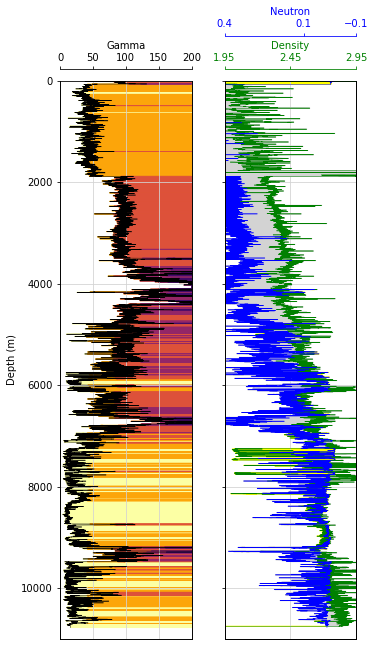

In [5]:
# Create a copy to manipulate
df_tc = df.copy()

# Filter to the logs we need and reasonable values
df_tc = df_tc[['GR','RHOZ','NPHI']]

make_plot(df_tc, 0, 11000)

The RHOZ log needs to be trimmed to reasonable values, and fortunately this removes all the other suspect
data as it occurs over the same interval. We are also dropping the first 2000 feet of data as it covers a
homogenous unit and is simply not interesting for this project.

In [6]:
df_tc = df_tc[df_tc['RHOZ'].between(1.8, 3.2)]

# Drop first 2000'
df_tc = df_tc[df_tc.index > 2000]

# Drop rows missing values
df_tc.dropna(inplace=True)

# Inspect
print("Shape of new DataFrame:", df_tc.shape)
df_tc.describe().T

Shape of new DataFrame: (17504, 3)


,count,mean,std,min,25%,50%,75%,max
GR,17504.00,73.08,66.39,3.92,22.49,75.86,100.44,1217.80
RHOZ,17504.00,2.56,0.19,1.83,2.41,2.57,2.71,3.17
NPHI,17504.00,0.18,0.15,-0.02,0.03,0.16,0.33,0.60


## Create Plot

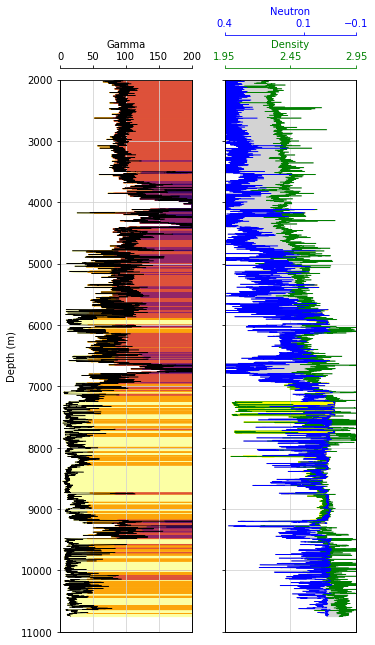

In [7]:
make_plot(df_tc, 2000, 11000)

### Scale (i.e. Standardize) Data
We need to scale our data so that they have unit variances. Think about cross plotting two variables
with wildly different scales, it can be very hard to visualize and interpret. The clustering algorithm
will want to make our clusters more/less circular in cross plot space, so if the variance among our features are
materially different this will lead to the variables with smaller variances getting more weight/being
more influential. This is standard practice on many data science and mathemetical optimization workflows.

`sklearn.StandardScaler` will transform our distributions to have a mean of 0 and a standard deviation of 1.

***Hint: there are other options that can be used in presence of outliers, such as `RobustScaler`.
In our case, the data seems to be clean of outliers, so we use `StandardScaler`.***

In [8]:
from sklearn.preprocessing import StandardScaler

# Create the scaler and standardize the data
scaler = StandardScaler()
df_tc_nrm = scaler.fit_transform(df_tc)

# Create DataFrame
df_tc_nrm = pd.DataFrame(df_tc_nrm, columns=df_tc.columns, index=df_tc.index)

# Inspect
print(df_tc_nrm.shape)
df_tc_nrm.describe().T

(17504, 3)


,count,mean,std,min,25%,50%,75%,max
GR,17504.00,-0.00,1.00,-1.04,-0.76,0.04,0.41,17.24
RHOZ,17504.00,0.00,1.00,-3.90,-0.82,0.05,0.76,3.23
NPHI,17504.00,-0.00,1.00,-1.38,-1.03,-0.13,1.01,2.84


## Build Model

Now, we create our model and specify how many clusters we want in our model. There are methods to determine
how many clusters we should look for, however when working with mixed mediums like rocks the decision is
rarely easily determined. Typically, iterative and interpretative approach works well. If we have too many clusters
we can always combine some together. If we have too few we may not identify an important rock types. We can also
specify other hyperparameters at this time, but the defaults meet our needs in this case.

***Hint: In unknown datasets, the Elbow Method can be used to determine initial number of clusters. In the elbow method
we try to explore the number of clusters versus explained variance in the dataset.***

More information: [Elbow Method](https://en.wikipedia.org/wiki/Elbow_method_(clustering))

In [9]:
# Create model
cluster_model = KMeans(n_clusters=6, random_state=42)

# Fit to our DataFrame
cluster_model.fit(df_tc_nrm)

# Create new dataframes to hold our cluster results
df_tc_cluster = df_tc.copy() 
df_tc_nrm_cluster = df_tc_nrm.copy()

# Get the cluster labels into our standardized and non-standardized DataFrames for visualization
df_tc_cluster['Clusters'] = cluster_model.labels_ + 1
df_tc_nrm_cluster['Clusters'] = cluster_model.labels_ + 1

## Custom Color Dictionary

In [10]:
cluster_color_dict = {
    1:'yellow',
    2:'CornflowerBlue',
    3:'orange',
    4:'green',
    5:'black',
    6:'fuchsia',
}

## View Clusters - 2D Scatter

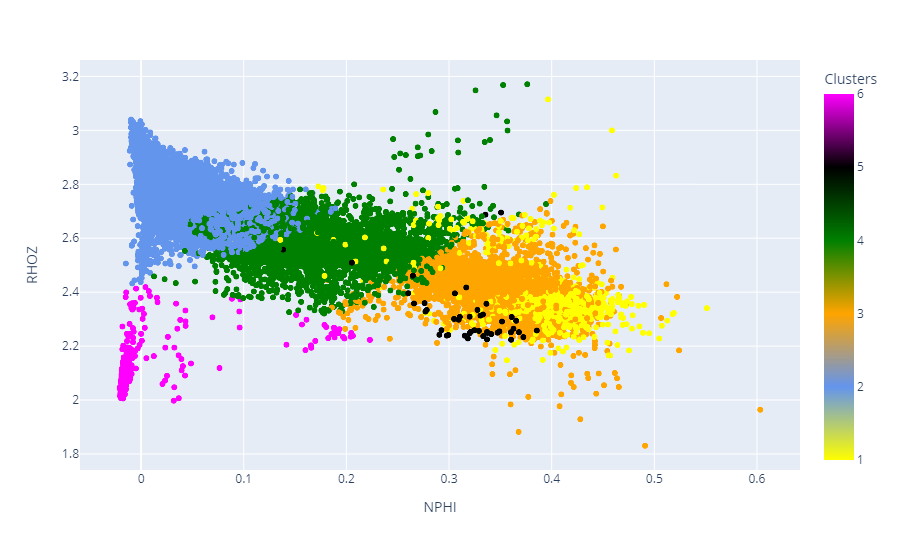

In [11]:
fig = px.scatter(df_tc_cluster, 
                 y='RHOZ', 
                 x='NPHI',
                 color = 'Clusters', 
                 color_continuous_scale=list(cluster_color_dict.values()),
                 width=900, height=550)

# Swap these two for interactive / static
# fig.show()
fig.show("png")

## View Clusters - 3D Scatter

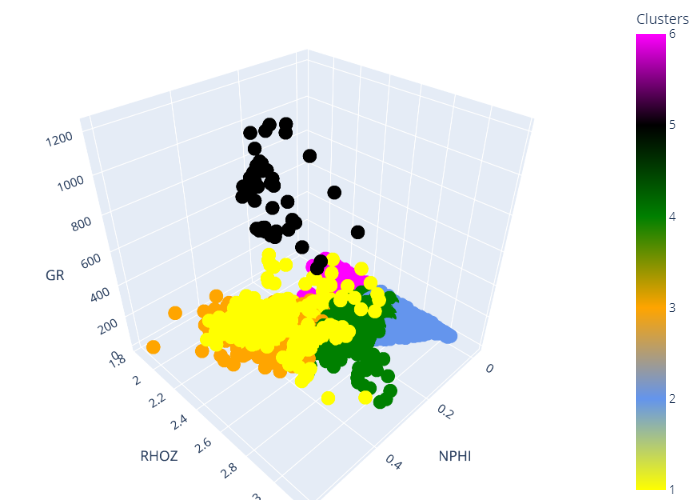

In [12]:
fig = px.scatter_3d(df_tc_cluster, 
                    x='NPHI', 
                    y='RHOZ', 
                    z='GR',
                    color='Clusters', 
                    color_continuous_scale=list(cluster_color_dict.values()))

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# Swap these two for interactive / static
# fig.show()
fig.show("png")

## View Clusters - Log Plot

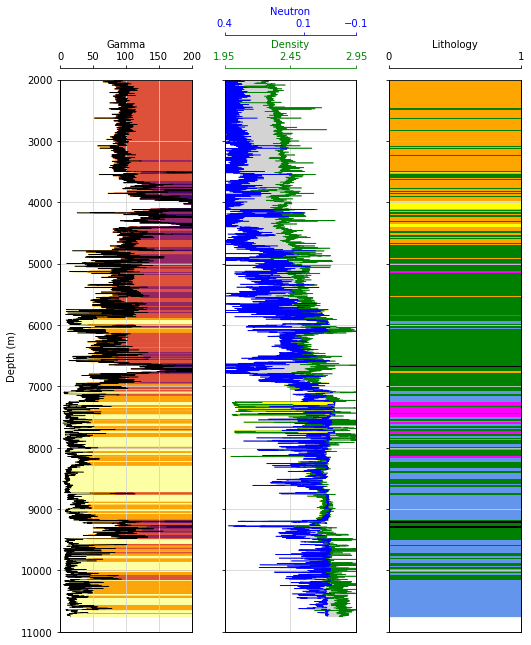

In [13]:
make_plot(df_tc_cluster, 2000, 11000)

## Interpretation:
Zooming in around 7300 feet, we can see that there are some very low gamma readings, and our density log (green) is
reading very low. This is a common response of salt; these are salt beds and they cause a host of issues for operators
all around the world. One of which we can see here, note how our green RHOB log appears to read erratically around
these beds, this is due to poor borehole conditions caused by these salt bodies.

Salt can also lead to well integrity issues and can cause a well to fail which is not only costly to fix but also
halts any production from that well. Identifying these layers and mapping them can help operators plan for special
casing designs over these intervals, possibly saving millions in future remediation.

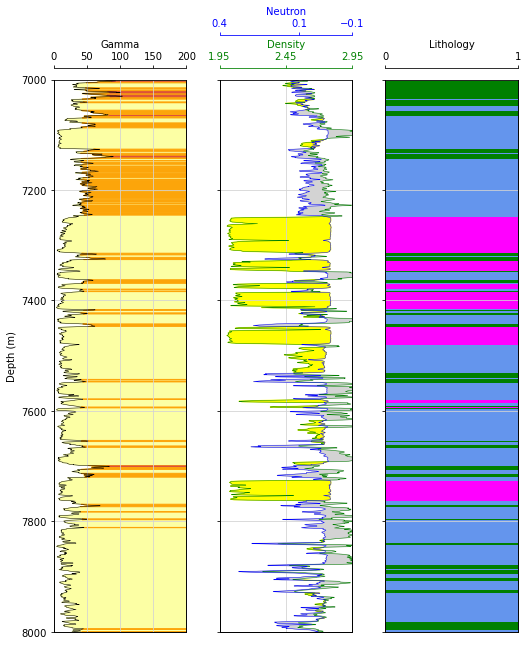

In [14]:
make_plot(df_tc_cluster, 7000, 8000)

- Moving further down section to the primary formation of interest in the basin (Bakken formation), we see some interesting trends. This is the only section of the entire well in which we see this cluster represented by the color black. These are the upper and lower bakken shales, and they are the primary source for the oil in the bakken petroleum system. The blue cluster is interpreted to be carbonate rock, which has little to no porosity and does not hold notable oil. The green cluster defines the primary reservoirs for the petroleum system, which are filled with hydrocarbons!

### Plot the Bakken Petroleum System

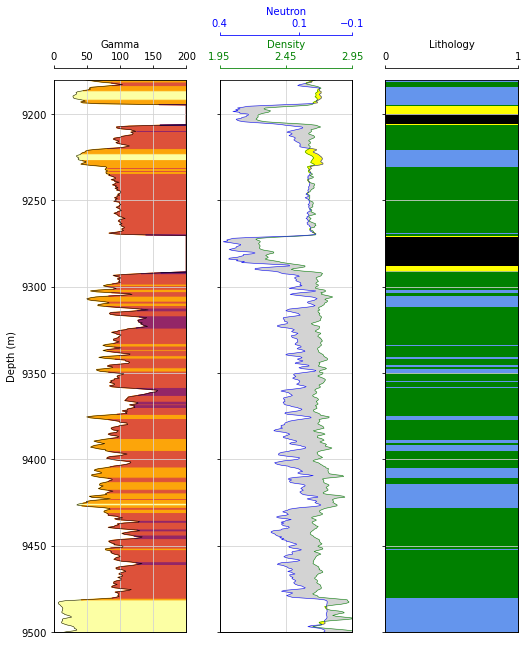

In [15]:
make_plot(df_tc_cluster, 9180, 9500)

## Getting Granular:
It can be valuable to identify the primary rock types for the entire basin using a clustering algorithm on the
entire section of rock as detailed above, but sometimes we want to get specific. Another use of this tool is to
limit our section of rock to a single interval and generate clusters to parse out this formation into smaller
units for classification/ranking. In this example I will zoom in on the Middle Bakken reservoir, which is the most
prolific formation in the Williston Basin.

In [16]:
df_tc_nrm_bakken = df_tc_nrm.copy()
df_tc_nrm_bakken = df_tc_nrm_bakken.loc[9208:9267, :]
df_tc_bakken = df_tc.copy()
df_tc_bakken = df_tc_bakken.loc[9208:9267, :]

# Create model
cluster_model_bakken = KMeans(n_clusters=6)

# Fit to our DataFrame
cluster_model_bakken.fit(df_tc_nrm_bakken)

# Create new dataframes to hold our cluster results
df_tc_bakken_cluster = df_tc_bakken.copy() 
df_tc_nrm_bakken_cluster = df_tc_nrm_bakken.copy()

# Get the cluster labels into our standardized and non-standardized DataFrames
df_tc_bakken_cluster['Clusters_bakken'] = cluster_model_bakken.labels_ + 1
df_tc_nrm_bakken_cluster['Clusters_bakken'] = cluster_model_bakken.labels_ + 1

If we were to limit our DataFrame and create a new clustering model on just this small subset of data, we would
return what is shown below.

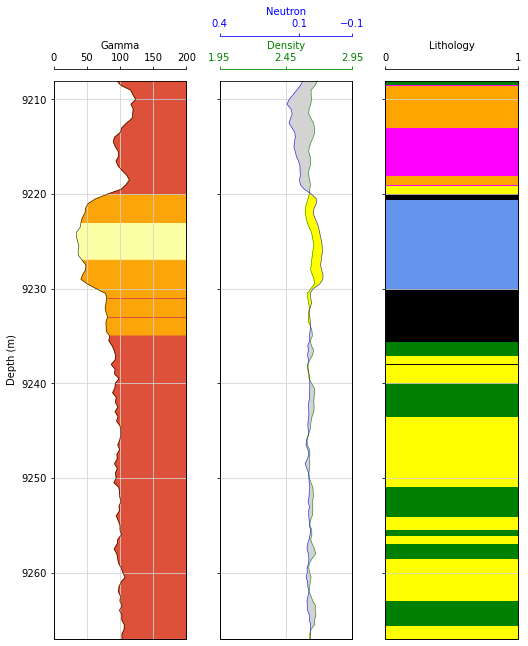

In [17]:
make_plot(df_tc_bakken_cluster, 9208, 9267)

### We can view these cluster in 3D:

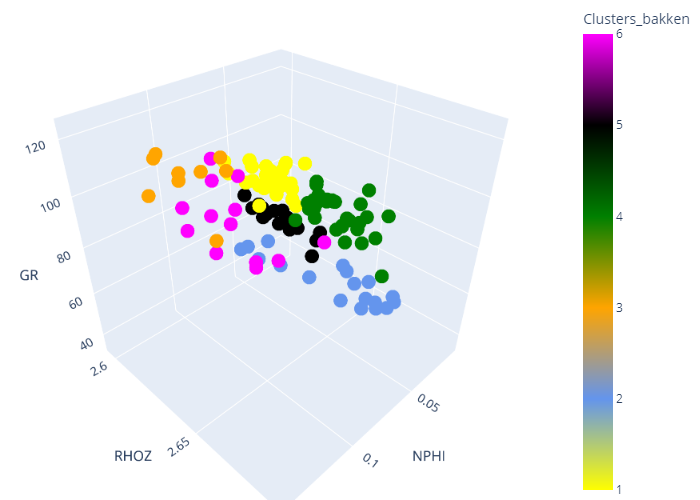

In [18]:
fig = px.scatter_3d(df_tc_bakken_cluster, 
                    x='NPHI', 
                    y='RHOZ', 
                    z='GR',
                    color='Clusters_bakken',
                    color_continuous_scale=list(cluster_color_dict.values()))

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# Swap these two for interactive / static
# fig.show()
fig.show("png")

This is a good example of possibly using too many clusters, in which the interpreter could then combine them!
We can interpret the two clusters appearing at the top of the log to both represent a dolomitic rock type, while
the two clusters immediately beneath represent a less favorable carbonate layer. The two bottommost clusters might
remain separate clusters, as the one appears to have slightly lower density, which could be a function of the
mineralogy or the porosity (either way it is systematically different).

This can be incredibly valuable, because different rock types have different reservoir characteristics and lead
to differential oil production. Knowing that in one area of the basin we see a large amount of the favorable pink/green
cluster (dolomite), we would expect to see better performance here than in another area that is dominated by the
carbonate bed (yellow/blue).

### Expansion / Future Work:
Two of the next steps / expansions to this work:

1. Within the Middle Bakken formation, using data from ***multiple*** wells.
2. Using a Gaussian Mixture Model with more data to explain more complex data distributions. [GMM](https://scikit-learn.org/stable/modules/mixture.html)

Why would these be valuable?

- Building a K-means model with data for one well, using 6 clusters, means that 6 groups will be identified
in this well (all clusters will be present)
- What if there are unique rock types in different parts of the basin, seen in some wells and not in others?
Our previously created model will not uniquely identify them and just know to add a new cluster, they will be
shoehorned into one of the existing cluster groups
- Building a model using the data from multiple wells, allows for the identification of all unique groups.
We would them use this master model to predict the clusters for each individual well. Some wells may in fact contain
all 6 clusters, while others are more homogenous and only have 2-3.
- Mapping the data spatially allows us to see where some rock types thicken, thin, or completely disappear which can
be incredibly valuable when comparing two different areas from a business development perspective.
- Our clusters will become more informative with mixture models, and boundaries will be more informative.